In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import os

from scipy import signal
from scipy import stats

In [2]:
# use fft to pull out frequency
def returnFFT(array, Fs):
    from scipy.fftpack import fft
    
    meanx = np.mean(array)
    fftr = fft(array - meanx)
        
    Nsamples = len(r) # number of points
    Nf = Nsamples # max Nyquist frequency is Nf/2
    
    TT = 1/Fs # resolution of frequency

    xf = np.linspace(0.0, 1.0/(2.0*TT), round(Nf/(2)))
    
    return(xf, fftr)

In [18]:
visitnum = ['FirstVisit/', 'Later7thVisit/' ,'LaterVisit/', 'LastVisit/']

n = []
peaks = []
freq = []
v = []
for visit in visitnum[:-1]:
    path = os.path.join('../dataFolders/PaperPipelineOutput/RadiusAndAngle_v2/', visit)
    Allpath = glob.glob(path + 'c*.csv')
    
    guidepath = os.path.join("../dataFolders/PaperPipelineOutput/FilteredTracks_v2/", visit)
    guide = pd.read_csv(guidepath + "AllVideoNames.csv")
    # print(guide.head())
    filesToRead = guide[guide.AutomatatedTracking != "TRUE"]
    
    outpathfig = os.path.join('../dataFolders/PaperPipelineOutput/Figures/v2/Dynamics-Rythmicity/',visit)
    
    print(visit)
    

    for path in Allpath:
        name = os.path.basename(path)[:-19]
    #     name =  'c-1_m19'
    #     path = [p for p in Allpath if name in p][0]
        if np.any(filesToRead.names.str.contains(name)):
            continue
    #     path = [data for data in Allpath if name in data]
        dataExamples = pd.read_csv(path)

        r = dataExamples.radial_distance_normalized.values
        r[r > 2.5] = np.nan

        # get the number of peaks
        ind, _ = signal.find_peaks(r, prominence=(0.5, ) )
        plt.plot(r)
        plt.plot(ind, r[ind], 'o')
        plt.savefig(outpathfig + name + '_peaks.pdf')
        plt.close()


        # testing the Welch method
        s = np.split(r, np.where(np.isnan(r))[0]+1)
        nanFreeSeg = max(s, key = len)
        f, Pxx = signal.welch(x= nanFreeSeg, 
                              fs=100.0, 
                              window='hanning',
                              nperseg = round(len(r)/5),
                              return_onesided=True, scaling='density')
        plt.plot(f, Pxx)
        plt.savefig(outpathfig + name + '_welchFFT.pdf')
        plt.close()

        max_f = f[np.argmax(Pxx)]

    #     print('max freq for %s is: %.2f Hz' % (name, f[np.argmax(Pxx)]))

        n.append(name)
        peaks.append(len(ind))
        freq.append(max_f)
        v.append(visit)

FirstVisit/


C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value e

Later7thVisit/


C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater


LaterVisit/


C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater


In [19]:
# save this data as a csv
datapath = r"../dataFolders/PaperPipelineOutput/Figures/v2/Paper/"
SweepDynamics = pd.DataFrame([n, peaks, freq, v]).T
SweepDynamics.columns = ['names', 'numPeaks', 'freq', 'visitNum']
SweepDynamics.to_csv(datapath + 'SweepDynamics.csv')

In [20]:
# plot the results
SweepDynamics[['flower', 'mothname']] = SweepDynamics.names.str.split(pat = '_', n = 2, expand = True)
SweepDynamics["numPeaks"] = pd.to_numeric(SweepDynamics["numPeaks"])
SweepDynamics["freq"] = pd.to_numeric(SweepDynamics["freq"])
SweepDynamics.head()
SweepDynamics.to_csv(datapath + 'SweepDynamics.csv')

In [21]:
SweepDynamics.visitNum.unique()

array(['FirstVisit/', 'Later7thVisit/', 'LaterVisit/'], dtype=object)

In [24]:
first = SweepDynamics[SweepDynamics.visitNum == 'FirstVisit/']
seven = SweepDynamics[SweepDynamics.visitNum == 'Later7thVisit/']
twenty = SweepDynamics[SweepDynamics.visitNum == 'LaterVisit/']

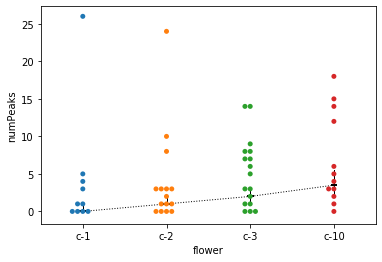

In [26]:
import seaborn as sns

f = sns.swarmlot(x = 'flower', y = 'numPeaks',
                  data = first,
                 order = ["c-1" ,"c-2", "c-3", "c-10"])
sns.pointplot(x="flower", y="numPeaks", 
              estimator = np.median, 
              data=SweepDynamics, 
#               ci = 'sd',
              markers = '_',
              linestyles = 'dotted',
              color = 'k',
             order = ["c-1" ,"c-2", "c-3", "c-10"])

plt.setp(f.lines,linewidth=1) 
ax = f.axes
# ax.set_ylim(-5,40)

(-0.5, 27)

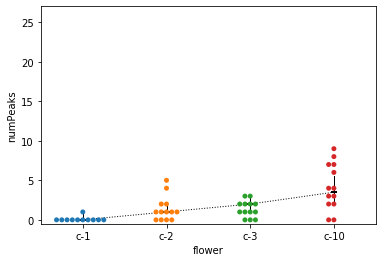

In [30]:
import seaborn as sns

f = sns.swarmplot(x = 'flower', y = 'numPeaks',
                  data = seven,
                 order = ["c-1" ,"c-2", "c-3", "c-10"])
sns.pointplot(x="flower", y="numPeaks", 
              estimator = np.median, 
              data=SweepDynamics, 
#               ci = 'sd',
              markers = '_',
              linestyles = 'dotted',
              color = 'k',
             order = ["c-1" ,"c-2", "c-3", "c-10"])

plt.setp(f.lines,linewidth=1) 
ax = f.axes
ax.set_ylim(-0.5,27)

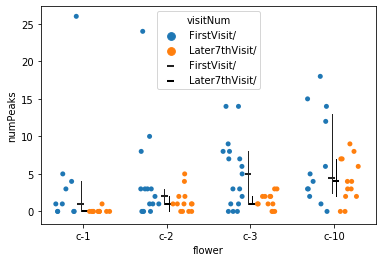

In [53]:
f = sns.stripplot(x = 'flower', y = 'numPeaks',
                  data = SweepDynamics[SweepDynamics.visitNum != 'LaterVisit/'],
                 hue = 'visitNum',
                 jitter=0.25,
                  dodge=True,
                 order = ["c-1" ,"c-2", "c-3", "c-10"])
sns.pointplot(x="flower", y="numPeaks", 
              estimator = np.median, 
              data=SweepDynamics[SweepDynamics.visitNum != 'LaterVisit/'],
              hue = 'visitNum',
              dodge = True,
#               ci = 'sd',
              markers = '_',
              linestyles = '',
              color = 'k',
             order = ["c-1" ,"c-2", "c-3", "c-10"])

plt.setp(f.lines,linewidth=1) 
ax = f.axes

plt.savefig(r"../dataFolders/PaperPipelineOutput/Figures/v2/Paper/" + 'NumSweeps.pdf')

In [54]:
for data in [first, seven, twenty]:
    m = data.groupby('flower')['numPeaks'].apply(np.median)
    print(m)

flower
c-1     1.0
c-10    4.5
c-2     2.0
c-3     5.0
Name: numPeaks, dtype: float64
flower
c-1     0.0
c-10    4.0
c-2     1.0
c-3     1.0
Name: numPeaks, dtype: float64
flower
c-1     0.0
c-10    2.0
c-2     1.0
c-3     1.0
Name: numPeaks, dtype: float64


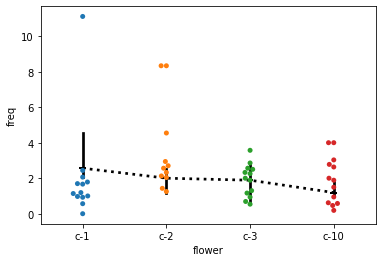

In [10]:
sns.swarmplot(x = 'flower', y = 'freq', data = SweepDynamics)
sns.pointplot(x="flower", y="freq", estimator = np.median, data=SweepDynamics, 
#               ci = 'sd',
              markers = '_',
              linestyles = 'dotted',
              color = 'k',
             order = ["c-1" ,"c-2", "c-3", "c-10"])

In [10]:
f = SweepDynamics.groupby('flower')['freq'].apply(np.median)
f

flower
c-1     1.754386
c-10    1.612903
c-2     1.125870
c-3     1.587302
Name: freq, dtype: float64

In [11]:
for name, grp in SweepDynamics.groupby('flower'):
    f,p = stats.normaltest(grp['numPeaks'])
    print('%s has %.2f stats and %.15f p value' %(name,f,p))
    if p < 0.5:
        print('%s is not normally distributed' %name)
    else:
        print('%s is normally distributed' %name)

c-1 has 31.15 stats and 0.000000172071952 p value
c-1 is not normally distributed
c-10 has 1.22 stats and 0.542521393422492 p value
c-10 is normally distributed
c-2 has 6.73 stats and 0.034583054539235 p value
c-2 is not normally distributed
c-3 has 0.84 stats and 0.657089618142994 p value
c-3 is normally distributed


C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))


In [50]:
c1_first = first.loc[first.flower == 'c-1', 'numPeaks'].values
c2_first = first.loc[first.flower == 'c-2', 'numPeaks'].values
c3_first = first.loc[first.flower == 'c-3', 'numPeaks'].values
c10_first = first.loc[first.flower == 'c-10', 'numPeaks'].values

c1_seven = seven.loc[seven.flower == 'c-1', 'numPeaks'].values
c2_seven = seven.loc[seven.flower == 'c-2', 'numPeaks'].values
c3_seven = seven.loc[seven.flower == 'c-3', 'numPeaks'].values
c10_seven = seven.loc[seven.flower == 'c-10', 'numPeaks'].values

# stats.kruskal(list(c1_first), list(c2_first), list(c3_first), list(c10_first), 
#               list(c1_seven), list(c2_seven), list(c3_seven), list(c10_seven))

stats.kruskal(list(c1_first), list(c2_first), list(c3_first), list(c10_first))

stats.kruskal(list(c1_seven), list(c2_seven), list(c3_seven), list(c10_seven))

KruskalResult(statistic=21.273990774170947, pvalue=9.234512330674461e-05)

In [51]:
subset = SweepDynamics[(SweepDynamics.visitNum != 'LaterVisit/') & (SweepDynamics.visitNum != 'FirstVisit/')]
subset['Combined'] = subset['flower'].str.cat(subset['visitNum'],sep="_")

C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [52]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

Subset = subset.dropna()
mc = MultiComparison(subset['numPeaks'], subset['Combined'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

             Multiple Comparison of Means - Tukey HSD, FWER=0.05             
       group1             group2       meandiff p-adj   lower   upper  reject
-----------------------------------------------------------------------------
c-10_Later7thVisit/ c-1_Later7thVisit/  -4.1399  0.001 -6.0945 -2.1852   True
c-10_Later7thVisit/ c-2_Later7thVisit/  -2.8462 0.0011 -4.7176 -0.9747   True
c-10_Later7thVisit/ c-3_Later7thVisit/  -2.8462 0.0011 -4.7176 -0.9747   True
 c-1_Later7thVisit/ c-2_Later7thVisit/   1.2937 0.3036  -0.661  3.2484  False
 c-1_Later7thVisit/ c-3_Later7thVisit/   1.2937 0.3036  -0.661  3.2484  False
 c-2_Later7thVisit/ c-3_Later7thVisit/      0.0    0.9 -1.8714  1.8714  False
-----------------------------------------------------------------------------
['c-10_Later7thVisit/' 'c-1_Later7thVisit/' 'c-2_Later7thVisit/'
 'c-3_Later7thVisit/']


In [13]:
for name, grp in SweepDynamics.groupby('flower'):
    f,p = stats.normaltest(grp['freq'])
    print('%s has %.2f stats and %.15f p value' %(name,f,p))
    if p < 0.5:
        print('%s is not normally distributed' %name)
    else:
        print('%s is normally distributed' %name)

c-1 has 5.44 stats and 0.065813023100548 p value
c-1 is not normally distributed
c-10 has 32.11 stats and 0.000000106376921 p value
c-10 is not normally distributed
c-2 has 0.37 stats and 0.832903878882945 p value
c-2 is normally distributed
c-3 has 1.63 stats and 0.442071921589624 p value
c-3 is not normally distributed


In [14]:
c1 = SweepDynamics.loc[SweepDynamics.flower == 'c-1', 'freq'].values
c2 = SweepDynamics.loc[SweepDynamics.flower == 'c-2', 'freq'].values
c3 = SweepDynamics.loc[SweepDynamics.flower == 'c-3', 'freq'].values
c10 = SweepDynamics.loc[SweepDynamics.flower == 'c-10', 'freq'].values
stats.kruskal(list(c1), list(c2), list(c3), list(c10))

KruskalResult(statistic=7.558426155236775, pvalue=0.05607608616161377)